# Demonstration notebook `deepSI_lite`

## Creating/obtaining train, val and test data in the form `Input_Output_data`

In [1]:
from deepSI_lite import Input_output_data
# from nonlinear_benchmarks import Input_output_data #equivilent as above
import numpy as np


#Example on how to create a Input_output_data
train = Input_output_data(u=np.array([1,2,3,4,5,1.,3]),y=np.array([1,-1,-3,10,11,12,13.]), sampling_time=1.0, name='my train set') 
test = Input_output_data(u=np.array([1,2,3,4,5,1.,3]),y=np.array([1,-1,-3,10,11,12,13.]), sampling_time=1.0, name='my test set') 
print(f'{train=}')
print(f'{test=}')

#getting a dataset
from nonlinear_benchmarks import Cascaded_Tanks
train, test = Cascaded_Tanks()
print(f'{train=}')
print(f'{test=}')

train=Input_output_data "my train set" u.shape=(7,) y.shape=(7,) sampling_time=1.0
test=Input_output_data "my test set" u.shape=(7,) y.shape=(7,) sampling_time=1.0
train=Input_output_data "train Cascaded_Tanks" u.shape=(1024,) y.shape=(1024,) sampling_time=4.0
test=Input_output_data "test Cascaded_Tanks" u.shape=(1024,) y.shape=(1024,) sampling_time=4.0 state_initialization_window_length=5


## Creating a SUBNET structure 

Creating a model starts by characterizing by which kind of data it will be applied on. Example: number of inputs (`nu=3` for 3 inputs) or scalar inputs `nu='scalar'`. Futhermore, it is also used to re-scale such to normalize and de-normalize the of `f`, `h` and `encoder` (see `The shap bits of deepSI_lite.ipynb` for details)

If you want to use zero-mean, std one normalization you can use `get_nu_ny_and_auto_norm` to characterize what kind of data you are working with.

This can be used to initilize the SUBNET method (https://arxiv.org/abs/2012.07697, https://www.sciencedirect.com/science/article/pii/S0005109823003710) as seen below.

In [2]:
from deepSI_lite import SUBNET, get_nu_ny_and_auto_norm
import torch

nx, nb, na = 2, 5, 5
nu, ny, norm = get_nu_ny_and_auto_norm(train)
torch.manual_seed(0)
model = SUBNET(nu, ny, norm, nx=nx, nb=nb, na=na)
# this model has four components:
# print(model.f)
# print(model.h)
# print(model.encoder)

r = lambda *x: torch.randn(*x)
x = r(1,model.nx)
u = r(1)
print(f'{model.f(x, u) = }') #the components can be evaluated in desired point

model.f(x, u) = tensor([[ 0.1258, -0.0477]], grad_fn=<AddBackward0>)


The SUBNET model has three components given by

$$
x_{k+1} = f_\theta(x_k, u_k)
$$
$$
\hat{y}_k = h_\theta(x_k)
$$
$$
x_0 = \psi_\theta(u_\text{past}, y_\text{past})
$$
where $\psi$ is the encoder that initializes the state. It is also possible to make $h_\theta(x_k, u_k)$ by setting `feedthrough=True`.


## Fitting is a function in deepSI_lite

Fitting can be done with the following function:

```python
def fit(
    model: Any,
    train: Any,
    val: Any,
    n_its: int,
    T: int = 50,
    batch_size: int = 256,
    stride: int = 1,
    val_freq: int = 250,
    optimizer: Any = None,
    device: Any = None,
    compile_mode: None | str = None,
    loss_fun: Any = compute_NMSE
) -> Any
```

where `T` is the trunctation lenght of the subsequences, `val_freq` is the frequency of which the validation loop will run.

You can also use `fit_minimal_implementation` which is a much smaller function but is missing some features.

In [3]:
from deepSI_lite.fitting import fit, fit_minimal_implementation
fit_result = fit(model, train=train[:900], val=train[900:], n_its=1_001, T=30, batch_size=64, val_freq=100)


Number of samples to train on = 866


  0%|          | 0/1001 [00:00<?, ?it/s]

it       0 NRMS loss nan NRMS val 0.85799!! nan samps/sec
it     100 NRMS loss 0.71028 NRMS val 0.98154   2375.90 samps/sec
it     200 NRMS loss 0.54199 NRMS val 1.16480   2397.30 samps/sec
it     300 NRMS loss 0.52809 NRMS val 1.21156   2400.29 samps/sec
it     400 NRMS loss 0.52359 NRMS val 1.23460   2397.93 samps/sec
it     500 NRMS loss 0.52090 NRMS val 0.82382!! 2382.15 samps/sec
it     600 NRMS loss 0.49679 NRMS val 0.81867!! 2369.23 samps/sec
it     700 NRMS loss 0.48311 NRMS val 0.85753   2298.35 samps/sec
it     800 NRMS loss 0.44600 NRMS val 0.75577!! 2236.32 samps/sec
it     900 NRMS loss 0.45688 NRMS val 0.75563!! 2132.13 samps/sec
it   1,000 NRMS loss 0.54257 NRMS val 0.75626   2057.71 samps/sec


Here `fit_result` contains information about the training. More information will be given on this later.

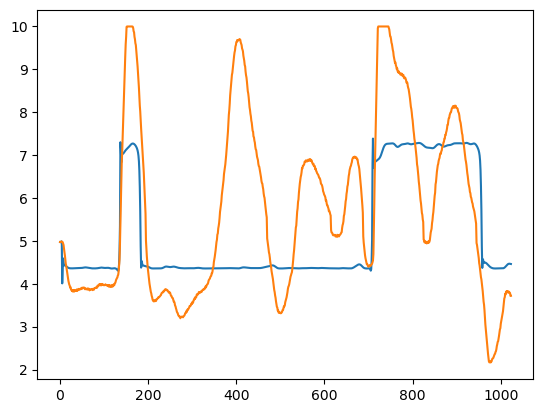

NRMS=85.26%
RMSE=1.7900 V


In [4]:
from matplotlib import pyplot as plt
plt.plot(model.simulate(test).y) #simulate is apply_experiment equivilent
plt.plot(test.y)
plt.show()
from nonlinear_benchmarks.error_metrics import NRMSE, RMSE
print(f'NRMS={NRMSE(test.y, model.simulate(test).y):.2%}')
print(f'RMSE={RMSE(test.y, model.simulate(test).y):.4f} V')

### Continous time SUBNET

`deepSI_lite` also contains options for continuous-time esitmation. For example: https://arxiv.org/abs/2204.09405 is implemented in `models.SUBNET_CT` given by the following structure.

$$
\dot{x}(t) = f_\theta^{\text{CT}}(x(t), u(t))
$$
$$
\hat{y}(t) = h_\theta(x(t))
$$
$$
x(0) = \psi_\theta(u_\text{past}, y_\text{past})
$$
where $\psi$ is the encoder that initializes the state.


In [5]:
import deepSI_lite as dsi
import torch
from deepSI_lite.models import SUBNET_CT
from deepSI_lite.fitting import fit
from nonlinear_benchmarks import Cascaded_Tanks
from deepSI_lite.networks import euler_integrator, rk4_integrator, rk45_integrator
train, test = Cascaded_Tanks()

nx, nb, na = 2, 5, 5
nu, ny, norm = dsi.get_nu_ny_and_auto_norm(train)
torch.manual_seed(0)
model_CT = dsi.SUBNET_CT(nu, ny, norm, nx=2, na=4, nb=4, integrator=euler_integrator)
train_dict = dsi.fit(model_CT, train, test, 1001, T=60, val_freq=20)

Number of samples to train on = 961


  0%|          | 0/1001 [00:00<?, ?it/s]

it       0 NRMS loss nan NRMS val 1.01385!! nan samps/sec
it      20 NRMS loss 0.61773 NRMS val 0.47273!! 2540.15 samps/sec
it      40 NRMS loss 0.36855 NRMS val 0.48453   2461.76 samps/sec
it      60 NRMS loss 0.33149 NRMS val 1.01785   2387.74 samps/sec
it      80 NRMS loss 0.29161 NRMS val 1.17273   2372.20 samps/sec
it     100 NRMS loss 0.25882 NRMS val 1.40911   2387.39 samps/sec
it     120 NRMS loss 0.24207 NRMS val 1.40752   2402.94 samps/sec
it     140 NRMS loss 0.23263 NRMS val 1.48823   2402.56 samps/sec
it     160 NRMS loss 0.22584 NRMS val 1.55652   2395.87 samps/sec
it     180 NRMS loss 0.21659 NRMS val 1.61769   2347.31 samps/sec
it     200 NRMS loss 0.21098 NRMS val 1.65873   2338.41 samps/sec
it     220 NRMS loss 0.20767 NRMS val 1.69023   2345.44 samps/sec
it     240 NRMS loss 0.20223 NRMS val 1.70139   2327.46 samps/sec
it     260 NRMS loss 0.19833 NRMS val 1.71365   2313.09 samps/sec
it     280 NRMS loss 0.19340 NRMS val 1.74223   2310.52 samps/sec
it     300 NRMS lo

### Changing the intergator

You can change out the integrator as desired as

In [6]:
from deepSI_lite.networks import euler_integrator, rk4_integrator, rk45_integrator
from nonlinear_benchmarks.error_metrics import RMSE

#this is a 3 step rk4_integrator
integrator = rk4_integrator
n_steps = 3
model_CT.integrator = lambda f,x,u,dt: integrator(f,x,u,dt, n_steps) 
print(f'RMSE={RMSE(test.y, model_CT.simulate(test).y):.4f} V')

RMSE=0.4718 V


## cutomizable SUBNET

If you want to parameterize differently (number of layers and different functions) than you can pass your desired `f`, `h` and `encoder` ($\psi_\theta$) into the SUBNET structure class.  

Keep in mind that these function need to have the following function characteristics where $b$ is the batch dimension.

$$f_\theta : \mathbb{R}^{b \times n_x} \times \mathbb{R}^{b \times n_u} \rightarrow \mathbb{R}^{b \times n_x}$$

$$h_\theta : \mathbb{R}^{b \times n_x} \times \mathbb{R}^{b \times n_u} \rightarrow \mathbb{R}^{b \times n_y} \text{\ if feedthrough=True else }h_\theta : \mathbb{R}^{b \times n_x} \rightarrow \mathbb{R}^{b \times n_y}$$

$$\psi_\theta : \mathbb{R}^{b \times n_b \times n_u} \times \mathbb{R}^{b \times n_a \times n_y} \rightarrow \mathbb{R}^{b \times n_x}$$

Or in the case that the input and output are scalars (`nu = 'scalar'` and `ny = 'scalar'`)

$$f_\theta : \mathbb{R}^{b \times n_x} \times \mathbb{R}^{b} \rightarrow \mathbb{R}^{b \times n_x}$$

$$h_\theta : \mathbb{R}^{b \times n_x} \times \mathbb{R}^{b} \rightarrow \mathbb{R}^{b} \text{\ if feedthrough=True else }h_\theta : \mathbb{R}^{b \times n_x} \rightarrow \mathbb{R}^{b}$$

$$\psi_\theta : \mathbb{R}^{b \times n_b} \times \mathbb{R}^{b \times n_a} \rightarrow \mathbb{R}^{b \times n_x}$$

If a simple multi layer perceptron or feed forward neural network (with linear residual layer) is desired you can use `MLP_res_net`.


In [7]:
from deepSI_lite.networks import MLP_res_net
from torch import nn
from deepSI_lite.models import SUBNET
from deepSI_lite import get_nu_ny_and_auto_norm
from nonlinear_benchmarks import Cascaded_Tanks
train, test = Cascaded_Tanks()
nx, nb, na = 2, 5, 5
nu, ny, norm = get_nu_ny_and_auto_norm(train)
feedthrough = False

f =       norm.f(       MLP_res_net(input_size = [nx , nu],                       output_size = nx, activation=nn.Sigmoid))
h =       norm.h(       MLP_res_net(input_size = [nx, nu] if feedthrough else nx, output_size = ny, n_hidden_layers=5, n_hidden_nodes=10))
encoder = norm.encoder( MLP_res_net(input_size = [(nb,nu) , (na,ny)],             output_size = nx, n_hidden_layers=1, n_hidden_nodes=15))

print(f) #has f(x,u) -> x with batch
print(h) #has h(x,u) -> y with batch if feedthrough = True else h(x) -> y
print(encoder) #has encoder(upast, ypast) -> x

print(SUBNET(nu, ny, norm, nx=nx, nb=nb, na=na, f=f, h=h, encoder=encoder))

IO_normalization_f(
  (fun): MLP_res_net(
    (net_res): Linear(in_features=3, out_features=2, bias=True)
    (net_nonlin): Sequential(
      (0): Linear(in_features=3, out_features=64, bias=True)
      (1): Sigmoid()
      (2): Linear(in_features=64, out_features=64, bias=True)
      (3): Sigmoid()
      (4): Linear(in_features=64, out_features=2, bias=True)
    )
  )
)
IO_normalization_h(
  (fun): MLP_res_net(
    (net_res): Linear(in_features=2, out_features=1, bias=True)
    (net_nonlin): Sequential(
      (0): Linear(in_features=2, out_features=10, bias=True)
      (1): Tanh()
      (2): Linear(in_features=10, out_features=10, bias=True)
      (3): Tanh()
      (4): Linear(in_features=10, out_features=10, bias=True)
      (5): Tanh()
      (6): Linear(in_features=10, out_features=10, bias=True)
      (7): Tanh()
      (8): Linear(in_features=10, out_features=10, bias=True)
      (9): Tanh()
      (10): Linear(in_features=10, out_features=1, bias=True)
    )
  )
)
IO_normalization_

## Creating you own SUBNET structure

A limitation in the `SUBNET` class is that the `f`, `h` and the `encoder` cannot share any parameters. If this is not the case than you can still create you own cutom SUBNET structure.

This is done by inhereting `Custom_SUBNET` and defining a forward method with the characteristic:
* `forward(upast, ypast, ufuture) = yfuture_sim`
  * `upast.shape = (batch_dim, nb, nu)`,
  * `ypast.shape = (batch_dim, na, ny)`,
  * `ufuture.shape = (batch_dim, T, nu)`,
  * `yfuture_sim.shape = (batch_dim, T, ny)`

(and removing `nu` and `ny` from these shapes if they are `'scalar'`)

Below you can find an example for a LPV structure, see: https://arxiv.org/abs/2204.04060

This structure does not accept `nu='scalar'` or `ny = 'scalar'` and thus 


In [8]:
from deepSI_lite.models import Custom_SUBNET, validate_custom_SUBNET_structure
from deepSI_lite import Norm, get_nu_ny_and_auto_norm
from deepSI_lite.networks import Bilinear, MLP_res_net
import torch
import numpy as np
class SUBNET_LPV(Custom_SUBNET):
    def __init__(self, nu, ny, norm:Norm, nx, n_schedual, na, nb, scheduling_net=None, A=None, B=None, C=None, D=None, encoder=None, feedthrough=True):
        if np.any((2*abs(norm.ymean)>norm.ystd).numpy()) or np.any((2*abs(norm.umean)>norm.ustd).numpy()):
            from warnings import warn
            warn('SUBNET_LPV assumes that the data is approximatly zero mean. Not doing so can lead to unintended behaviour.')
        assert isinstance(nu, int) and isinstance(ny, int) and isinstance(n_schedual, int) and feedthrough, 'SUBNET_LPV requires the input, output schedualing parameter to be vectors and feedthrough to be present'
        super().__init__()
        self.nu, self.ny, self.norm, self.nx, self.n_schedual, self.na, self.nb, self.feedthrough = nu, ny, norm, nx, n_schedual, na, nb, feedthrough
        self.A = A if A is not None else Bilinear(n_in=nx, n_out=nx, n_schedual=n_schedual)
        self.B = B if B is not None else Bilinear(n_in=nu, n_out=nx, n_schedual=n_schedual, std_input=norm.ustd)
        self.C = C if C is not None else Bilinear(n_in=nx, n_out=ny, n_schedual=n_schedual, std_output=norm.ystd)
        self.D = D if D is not None else Bilinear(n_in=nu, n_out=ny, n_schedual=n_schedual, std_output=norm.ystd, std_input=norm.ustd)
        self.encoder = encoder if encoder is not None else norm.encoder(MLP_res_net(input_size = [(nb,nu) , (na,ny)], output_size = nx))
        self.scheduling_net = scheduling_net if scheduling_net is not None else norm.f(MLP_res_net(input_size = [nx , nu], output_size = n_schedual))
        validate_custom_SUBNET_structure(self) #does checks if forward is working as intended
    
    def forward(self, upast: torch.Tensor, ypast: torch.Tensor, ufuture: torch.Tensor, yfuture: torch.Tensor=None):
        mv = lambda A, x: torch.bmm(A, x[:, :, None])[:,:,0] #batched matrix vector multiply
        yfuture_sim = []
        x = self.encoder(upast, ypast)
        for u in ufuture.swapaxes(0,1): #iterate over time
            p = self.scheduling_net(x, u)
            A, B, C, D = self.A(p), self.B(p), self.C(p), self.D(p)
            y = mv(C, x) + mv(D, u)
            x = mv(A, x) + mv(B, u)
            yfuture_sim.append(y)
        return torch.stack(yfuture_sim, dim=1)

from nonlinear_benchmarks import Silverbox
train, test = Silverbox(atleast_2d=True)
nx, nb, na = 2, 5, 5
nu, ny, norm = get_nu_ny_and_auto_norm(train)

SUBNET_LPV(nu, ny, norm, nx, n_schedual=2, na=na, nb=nb)

SUBNET_LPV(
  (A): Bilinear()
  (B): Bilinear()
  (C): Bilinear()
  (D): Bilinear()
  (encoder): IO_normalization_encoder(
    (fun): MLP_res_net(
      (net_res): Linear(in_features=10, out_features=2, bias=True)
      (net_nonlin): Sequential(
        (0): Linear(in_features=10, out_features=64, bias=True)
        (1): Tanh()
        (2): Linear(in_features=64, out_features=64, bias=True)
        (3): Tanh()
        (4): Linear(in_features=64, out_features=2, bias=True)
      )
    )
  )
  (scheduling_net): IO_normalization_f(
    (fun): MLP_res_net(
      (net_res): Linear(in_features=3, out_features=2, bias=True)
      (net_nonlin): Sequential(
        (0): Linear(in_features=3, out_features=64, bias=True)
        (1): Tanh()
        (2): Linear(in_features=64, out_features=64, bias=True)
        (3): Tanh()
        (4): Linear(in_features=64, out_features=2, bias=True)
      )
    )
  )
)

## Exporting functions

This can for since be loaded in https://netron.app/ to see the computation graph or with MATLAB or even CasaDI with some effort.

In [9]:
import torch
from torch import nn
class Fun(nn.Module):
    def __init__(self, f, model):
        super().__init__()
        self.f = f
        self.model = model
    def forward(self, *args, **kwargs):
        with torch.no_grad():
            return self.f(*args, **kwargs)

f = Fun(model.f, model)
x = torch.zeros((1, nx))
u = torch.zeros((1,1))[0] if model.nu == 'scalar' else torch.zeros((1,model.nu))

torch.onnx.export(
    f,                  # the model (in this case Fun class wrapping your model)
    (x, u),             # input tensors (in this case x and u)
    "f.onnx",       # file name or file path where the model will be saved
    opset_version=12    # specify the ONNX opset version
)



## Reproducability

If you set a manual seed before creating the model than the results is always the same. 

In [10]:
from deepSI_lite.models import SUBNET_LPV, SUBNET, SUBNET_CT
from deepSI_lite.normalization import Norm, get_nu_ny_and_auto_norm
from deepSI_lite.fitting import fit
from nonlinear_benchmarks import Silverbox
import numpy as np
import torch

train_val, tests = Silverbox()
test = tests[0]
s = int(0.95*len(train_val))
train, val = train_val[:s], train_val[s:]
nu, ny, norm = get_nu_ny_and_auto_norm(train_val)

for _ in range(2):
    torch.manual_seed(0)
    subnet = SUBNET(nu, ny, norm, nx=4, nb=20, na=20)
    fit_res_subnet = fit(subnet, train, val, n_its=100, val_freq=10)


Number of samples to train on = 61739


  0%|          | 0/100 [00:00<?, ?it/s]

it       0 NRMS loss nan NRMS val 0.99626!! nan samps/sec
it      10 NRMS loss 0.96911 NRMS val 0.91461!! 3760.21 samps/sec
it      20 NRMS loss 0.88075 NRMS val 0.87685!! 3653.96 samps/sec
it      30 NRMS loss 0.84420 NRMS val 0.84332!! 3606.04 samps/sec
it      40 NRMS loss 0.75531 NRMS val 0.58872!! 3572.56 samps/sec
it      50 NRMS loss 0.51822 NRMS val 0.54371!! 3473.37 samps/sec
it      60 NRMS loss 0.45830 NRMS val 0.49202!! 3351.09 samps/sec
it      70 NRMS loss 0.40896 NRMS val 0.41274!! 3251.64 samps/sec
it      80 NRMS loss 0.36910 NRMS val 0.36029!! 3136.77 samps/sec
it      90 NRMS loss 0.32021 NRMS val 0.31022!! 3091.40 samps/sec
Number of samples to train on = 61739


  0%|          | 0/100 [00:00<?, ?it/s]

it       0 NRMS loss nan NRMS val 0.99626!! nan samps/sec
it      10 NRMS loss 0.96911 NRMS val 0.91461!! 2925.93 samps/sec
it      20 NRMS loss 0.88075 NRMS val 0.87685!! 2915.90 samps/sec
it      30 NRMS loss 0.84420 NRMS val 0.84332!! 2839.59 samps/sec
it      40 NRMS loss 0.75531 NRMS val 0.58872!! 2925.99 samps/sec
it      50 NRMS loss 0.51822 NRMS val 0.54371!! 2889.10 samps/sec
it      60 NRMS loss 0.45830 NRMS val 0.49202!! 2890.51 samps/sec
it      70 NRMS loss 0.40896 NRMS val 0.41274!! 2874.88 samps/sec
it      80 NRMS loss 0.36910 NRMS val 0.36029!! 2916.87 samps/sec
it      90 NRMS loss 0.32021 NRMS val 0.31022!! 2898.76 samps/sec


## Regularization and custom cost functions

In `fit` you can give custom cost function like by giving an argument for `loss_fun`.

In [11]:
from deepSI_lite import SUBNET, get_nu_ny_and_auto_norm
from deepSI_lite.fitting import compute_NMSE
import torch
from nonlinear_benchmarks import Cascaded_Tanks
import numpy as np
train, test = Cascaded_Tanks()

nx, nb, na = 2, 5, 5
nu, ny, norm = get_nu_ny_and_auto_norm(train)
model = SUBNET(nu, ny, norm, nx=nx, nb=nb, na=na)

def ridge_L2_regularization(model, upast, ypast, ufuture, yfuture, kappa=1):
    yfuture_model = model(upast, ypast, ufuture)
    amp = torch.stack([(p**2).sum() for p in model.parameters()])/torch.as_tensor([p.numel() for p in model.parameters()])
    return ((yfuture-yfuture_model)**2/model.norm.ystd**2).mean() + torch.mean(amp)*kappa

from deepSI_lite import fit
kappa = 0
#create a partially filled function
my_loss = lambda *args: ridge_L2_regularization(*args, kappa=kappa)
train_dict = fit(model, train, test, n_its=101, T=40, batch_size=64, val_freq=100, loss_fun=my_loss, val_fun=compute_NMSE)

Number of samples to train on = 980


  0%|          | 0/101 [00:00<?, ?it/s]

it       0 NRMS loss nan NRMS val 1.04559!! nan samps/sec
it     100 NRMS loss 0.81547 NRMS val 0.70507!! 931.60 samps/sec


## Training/fitting

In [12]:
import deepSI_lite as dsi
import nonlinear_benchmarks as nlb
from matplotlib import pyplot as plt

train_val, test = nlb.Silverbox()
nu, ny, norm = dsi.get_nu_ny_and_auto_norm(train_val)
train_val, test = norm.transform(train_val), norm.transform(test)
s = int(len(train_val)*0.95)
train, val = train_val[:s], train_val[s:]
model = dsi.models.SUBNET(nu, ny, dsi.Norm(0, 1, 0, 1), nx=4)
train_dict = dsi.fit(model, train, val, n_its=201, val_freq=10)


Number of samples to train on = 61739


  0%|          | 0/201 [00:00<?, ?it/s]

it       0 NRMS loss nan NRMS val 0.94222!! nan samps/sec
it      10 NRMS loss 0.83779 NRMS val 0.71031!! 3240.97 samps/sec
it      20 NRMS loss 0.53195 NRMS val 0.37894!! 3157.13 samps/sec
it      30 NRMS loss 0.35080 NRMS val 0.31227!! 2786.36 samps/sec
it      40 NRMS loss 0.27582 NRMS val 0.28759!! 2652.22 samps/sec
it      50 NRMS loss 0.25068 NRMS val 0.25593!! 2545.93 samps/sec
it      60 NRMS loss 0.22850 NRMS val 0.23592!! 2676.62 samps/sec
it      70 NRMS loss 0.20390 NRMS val 0.21209!! 2779.96 samps/sec
it      80 NRMS loss 0.18199 NRMS val 0.18607!! 2866.99 samps/sec
it      90 NRMS loss 0.16168 NRMS val 0.15986!! 2939.96 samps/sec
it     100 NRMS loss 0.13624 NRMS val 0.13161!! 3004.65 samps/sec
it     110 NRMS loss 0.11548 NRMS val 0.11078!! 3049.02 samps/sec
it     120 NRMS loss 0.09990 NRMS val 0.09464!! 3093.83 samps/sec
it     130 NRMS loss 0.08603 NRMS val 0.08397!! 3128.13 samps/sec
it     140 NRMS loss 0.08553 NRMS val 0.07959!! 3162.13 samps/sec
it     150 NRMS lo

The training dict contains a lot of information as seen below:

In [13]:
train_dict.keys()
# - 'best_model': The best model (with the lowest validation loss).
# - 'best_optimizer_state': Optimizer state when the best model was found.
# - 'last_model': The model at the end of training.
# - 'last_optimizer_state': The optimizer state at the end of training.
# - 'NRMS_train': Training loss history (normalized root mean square error).
# - 'NRMS_val': Validation loss history (normalized root mean square error).
# - 'samples/sec': Number of data samples processed per second.
# - 'val_freq': Validation frequency.
# - 'batch_size': Batch size used during training.
# - 'it_counter': List of iteration counts corresponding to each validation point.

dict_keys(['best_model', 'best_optimizer_state', 'last_model', 'last_optimizer_state', 'NRMS_train', 'NRMS_val', 'samples/sec', 'val_freq', 'batch_size', 'it_counter'])

### Trainig curve plots

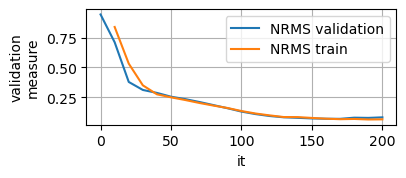

In [14]:
import numpy as np
plt.figure(figsize=(4,1.5))
plt.plot(train_dict['it_counter'], train_dict['NRMS_val'])
plt.plot(train_dict['it_counter'], train_dict['NRMS_train'])
plt.legend(['NRMS validation', 'NRMS train'])
plt.grid(); plt.xlabel('it'); plt.ylabel('validation\nmeasure')
plt.show()

## Restarting training

If you want to restart training with the same optimizer you can use:

In [15]:
import torch
model = train_dict['last_model']

optimizer = torch.optim.Adam(model.parameters())
optimizer.load_state_dict(train_dict['last_optimizer_state'])

train_dict = dsi.fit(model, train, val, n_its=201, val_freq=10, optimizer=optimizer)


Number of samples to train on = 61739


  0%|          | 0/201 [00:00<?, ?it/s]

it       0 NRMS loss nan NRMS val 0.06717!! nan samps/sec
it      10 NRMS loss 0.06928 NRMS val 0.10416   3613.17 samps/sec
it      20 NRMS loss 0.08278 NRMS val 0.09314   3581.78 samps/sec
it      30 NRMS loss 0.07425 NRMS val 0.06692!! 3657.46 samps/sec
it      40 NRMS loss 0.06091 NRMS val 0.05533!! 3637.38 samps/sec
it      50 NRMS loss 0.06163 NRMS val 0.08280   3630.24 samps/sec
it      60 NRMS loss 0.06084 NRMS val 0.05746   3643.04 samps/sec
it      70 NRMS loss 0.05917 NRMS val 0.05523!! 3650.76 samps/sec
it      80 NRMS loss 0.05511 NRMS val 0.06172   3655.92 samps/sec
it      90 NRMS loss 0.05593 NRMS val 0.05128!! 3661.73 samps/sec
it     100 NRMS loss 0.06536 NRMS val 0.11852   3670.61 samps/sec
it     110 NRMS loss 0.06302 NRMS val 0.05014!! 3665.50 samps/sec
it     120 NRMS loss 0.05203 NRMS val 0.05096   3660.10 samps/sec
it     130 NRMS loss 0.04926 NRMS val 0.05559   3664.06 samps/sec
it     140 NRMS loss 0.05323 NRMS val 0.06890   3558.49 samps/sec
it     150 NRMS lo

### Recovering from a crash

After a crash (e.g. a forced windows update) you can recover the training progress with the following steps:

In [16]:
import deepSI_lite as dsi
folder = dsi.fitting.get_checkpoint_dir()
print('Training results saving directory:', folder) #you can manually go here
import cloudpickle
train_dict = cloudpickle.load(open(folder + 'SUBNET-mmBCKg.pth','rb'))
# train_dict.keys() contains all the info 
model = train_dict['best_model']


Training results saving directory: C:\Users\s143190\AppData\Local\deepSI-checkpoints/


## n-step errors

In [17]:
import deepSI_lite as dsi
import nonlinear_benchmarks as nlb
from matplotlib import pyplot as plt

train_val, test = nlb.Silverbox()
nu, ny, norm = dsi.get_nu_ny_and_auto_norm(train_val)
train_val, test = norm.transform(train_val), norm.transform(test) #normalize data
s = int(len(train_val)*0.95)
train, val = train_val[:s], train_val[s:]
model = dsi.models.SUBNET(nu, ny, dsi.Norm(0, 1, 0, 1), nx=4)
train_dict = dsi.fit(model, train, val, n_its=1001, val_freq=100)


Number of samples to train on = 61739


  0%|          | 0/1001 [00:00<?, ?it/s]

it       0 NRMS loss nan NRMS val 1.03830!! nan samps/sec
it     100 NRMS loss 0.51301 NRMS val 0.22233!! 3722.45 samps/sec
it     200 NRMS loss 0.13273 NRMS val 0.10766!! 3718.70 samps/sec
it     300 NRMS loss 0.08181 NRMS val 0.10403!! 3452.77 samps/sec
it     400 NRMS loss 0.06251 NRMS val 0.05875!! 3459.69 samps/sec
it     500 NRMS loss 0.06062 NRMS val 0.07423   3515.20 samps/sec
it     600 NRMS loss 0.07960 NRMS val 0.10815   3547.76 samps/sec
it     700 NRMS loss 0.04887 NRMS val 0.04599!! 3534.32 samps/sec
it     800 NRMS loss 0.04277 NRMS val 0.05058   3555.40 samps/sec
it     900 NRMS loss 0.05535 NRMS val 0.07718   3570.94 samps/sec
it   1,000 NRMS loss 0.04376 NRMS val 0.04581!! 3576.08 samps/sec


In [18]:
(upast, ypast, ufuture, yfuture), ids = model.create_arrays(test, T=100, stride=10)
import torch
with torch.no_grad():
    yfuture_pred = model(upast[ids], ypast[ids], ufuture[ids])

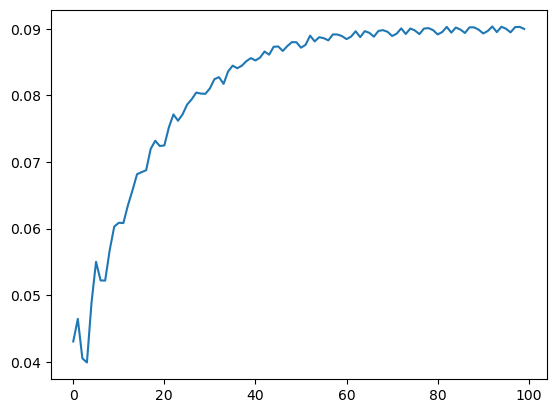

In [19]:
RMS_time = ((yfuture_pred - yfuture[ids])**2).mean(0)**0.5
plt.plot(RMS_time)
plt.show()